In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath("../"))

In [ ]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch import optim
import numpy as np
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
import random
from models.unet import UNet
from models.slim_unet import SlimUNet
from data_loader import prepare_datasets
from evaluate import dice_coeff,iou_score

# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
def train_epoch(model, train_loader, optimizer, criterion, device, accumulation_steps=4):
    model.train()
    epoch_loss = 0.0
    scaler = GradScaler()
    optimizer.zero_grad()

    with tqdm(total=len(train_loader), desc='Training') as pbar:
        for i, (images, masks, _) in enumerate(train_loader):  # Discard label
            images, masks = images.to(device), masks.to(device)

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks) / accumulation_steps

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            epoch_loss += loss.item() * accumulation_steps
            pbar.update(1)
            pbar.set_postfix({'loss': loss.item() * accumulation_steps})

    return epoch_loss / len(train_loader)

In [4]:
def validate(model, val_loader, criterion, device, threshold=0.5, visualize=False):
    model.eval()
    val_metrics = {
        'loss': 0.0, 'dice': 0.0, 'iou': 0.0,
        'precision': 0.0, 'recall': 0.0, 'f1': 0.0,
        'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0
    }
    val_count = 0
    per_image_metrics = []
    fig = None

    with torch.no_grad():
        for images, masks, _ in tqdm(val_loader, desc='Validation'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            sigmoid_outputs = torch.sigmoid(outputs)
            
            val_metrics['loss'] += criterion(outputs, masks).item()
            pred = (sigmoid_outputs > threshold).float()
            
            # Visualization
            if visualize and fig is None and images.size(0) > 0:
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(images[0].cpu().permute(1, 2, 0)[:, :, :3])
                axes[0].set_title("Input")
                axes[1].imshow(masks[0].cpu().squeeze(), cmap='gray')
                axes[1].set_title("Ground Truth")
                axes[2].imshow(pred[0].cpu().squeeze(), cmap='gray')
                axes[2].set_title(f"Prediction (th={threshold:.2f})")
                plt.show()
            
            # Metrics calculation
            batch_metrics = {}
            batch_metrics['dice'] = dice_coeff(sigmoid_outputs, masks).item()
            batch_metrics['iou'] = iou_score(sigmoid_outputs, masks).item()
            
            pred_flat = pred.view(-1)
            masks_flat = masks.view(-1)
            
            tp = torch.sum((pred_flat == 1) & (masks_flat == 1)).item()
            fp = torch.sum((pred_flat == 1) & (masks_flat == 0)).item()
            tn = torch.sum((pred_flat == 0) & (masks_flat == 0)).item()
            fn = torch.sum((pred_flat == 0) & (masks_flat == 1)).item()
            
            batch_metrics['precision'] = tp / (tp + fp) if (tp + fp) > 0 else 0
            batch_metrics['recall'] = tp / (tp + fn) if (tp + fn) > 0 else 0
            batch_metrics['f1'] = 2 * (batch_metrics['precision'] * batch_metrics['recall']) / (
                batch_metrics['precision'] + batch_metrics['recall']) if (
                batch_metrics['precision'] + batch_metrics['recall']) > 0 else 0
            
            for i in range(images.size(0)):
                per_image_metrics.append({
                    'dice': dice_coeff(sigmoid_outputs[i:i+1], masks[i:i+1]).item(),
                    'iou': iou_score(sigmoid_outputs[i:i+1], masks[i:i+1]).item(),
                })
            
            for k in batch_metrics:
                val_metrics[k] += batch_metrics[k]
            
            val_metrics['tp'] += tp
            val_metrics['fp'] += fp
            val_metrics['tn'] += tn
            val_metrics['fn'] += fn
            val_count += 1
    
    # Calculate averages
    for k in ['loss', 'dice', 'iou', 'precision', 'recall', 'f1']:
        val_metrics[k] /= max(1, val_count)
    
    # Global metrics
    total_tp = val_metrics['tp']
    total_fp = val_metrics['fp']
    total_fn = val_metrics['fn']
    
    val_metrics['global_precision'] = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    val_metrics['global_recall'] = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    val_metrics['global_f1'] = 2 * (val_metrics['global_precision'] * val_metrics['global_recall']) / (
        val_metrics['global_precision'] + val_metrics['global_recall']) if (
        val_metrics['global_precision'] + val_metrics['global_recall']) > 0 else 0
    
    # Standard deviations
    dice_values = [m['dice'] for m in per_image_metrics]
    iou_values = [m['iou'] for m in per_image_metrics]
    val_metrics['dice_std'] = np.std(dice_values) if dice_values else 0
    val_metrics['iou_std'] = np.std(iou_values) if iou_values else 0
    
    return val_metrics

In [5]:
def find_optimal_threshold(model, val_loader, device, n_thresholds=20):
    model.eval()
    thresholds = np.linspace(0.1, 0.9, n_thresholds)
    best_threshold = 0.5
    best_f1 = 0.0

    with torch.no_grad():
        for th in thresholds:
            val_metrics = validate(model, val_loader, nn.BCEWithLogitsLoss(), device, threshold=th, visualize=False)
            if val_metrics['global_f1'] > best_f1:
                best_f1 = val_metrics['global_f1']
                best_threshold = th
    return best_threshold

In [6]:
def compute_pos_weight(dataset):
    total_pos = 0
    total_neg = 0

    for item in dataset:
        # Handle both cases where dataset returns (image, mask) or (image, mask, label)
        if len(item) == 3:
            _, mask, _ = item  # Discard image and label
        else:
            _, mask = item  # Discard image
        
        # Assuming mask is shape (1, H, W) or (H, W)
        mask = mask.float()
        total_pos += mask.sum().item()
        total_neg += (1 - mask).sum().item()

    return total_neg / (total_pos + 1e-8)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()

        intersection = (probs * targets).sum(dim=(1,2,3))
        union = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [ ]:
def test_model(model, test_loader, criterion, device):
    print("\nEvaluating on test set...")
    model.load_state_dict(torch.load('../outputs/models/Slim_Unet_model.pth'))
    with open('../outputs/models/Slim_Unet_threshold.txt', 'r') as f:
        best_threshold = float(f.read())
    
    test_metrics = validate(model, test_loader, criterion, device, best_threshold, visualize=True)
    
    print("\n--- Test Metrics ---")
    print(f"Validation Threshold Used: {best_threshold:.2f}")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Dice: {test_metrics['dice']:.4f}±{test_metrics['dice_std']:.4f}")
    print(f"Test IoU: {test_metrics['iou']:.4f}±{test_metrics['iou_std']:.4f}")
    print(f"Precision: {test_metrics['global_precision']:.4f} | Recall: {test_metrics['global_recall']:.4f} | F1: {test_metrics['global_f1']:.4f}")

In [8]:
def train_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Hyperparameters
    batch_size = 4
    accumulation_steps = 2  # Effective batch size = 8
    num_epochs = 50
    learning_rate = 1e-4
    patience = 10

    # Prepare data
    try:
        train_set, val_set, test_set = prepare_datasets('../data/processed')
    except Exception as e:
        print(f"Error preparing datasets: {e}")
        return
    
    pos_weight_value = compute_pos_weight(train_set)
    pos_weight = torch.tensor([pos_weight_value]).to(device)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                             num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                           num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

    # Initialize model
    model = SlimUNet(n_channels=4, n_classes=1).to(device)
    bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    dice = DiceLoss()
    
    def combined_loss_fn(logits, targets):
        return bce(logits, targets) + dice(logits, targets)
    
    criterion = combined_loss_fn
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

    best_dice = 0.0
    best_threshold = 0.5
    no_improve = 0

    try:
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            
            # Training
            avg_train_loss = train_epoch(model, train_loader, optimizer, criterion, 
                                       device, accumulation_steps)
            
            # Validation with dynamic threshold
            threshold = find_optimal_threshold(model, val_loader, device)
            metrics = validate(model, val_loader, criterion, device, 
                             threshold, visualize=(epoch % 10 == 0))
            
            print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {metrics['loss']:.4f}")
            print(f"Val Dice: {metrics['dice']:.4f}±{metrics['dice_std']:.4f} | Threshold: {threshold:.2f}")
            print(f"Precision: {metrics['global_precision']:.4f} | Recall: {metrics['global_recall']:.4f} | F1: {metrics['global_f1']:.4f}")

            # Early stopping and model saving
            if metrics['dice'] > best_dice:
                best_dice = metrics['dice']
                best_threshold = threshold
                torch.save(model.state_dict(), 'best_model.pth')
                with open('best_threshold.txt', 'w') as f:
                    f.write(str(best_threshold))
                no_improve = 0
                print(f"New best model! Val Dice: {best_dice:.4f}")
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"No improvement for {patience} epochs. Early stopping!")
                    break

            scheduler.step(metrics['dice'])

    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
        
    test_model(model, test_loader, criterion, device)

Using device: cuda
Train: 8458, Val: 1058, Test: 1058

Epoch 1/50


Validation:   0%|          | 0/265 [00:00<?, ?it/s]

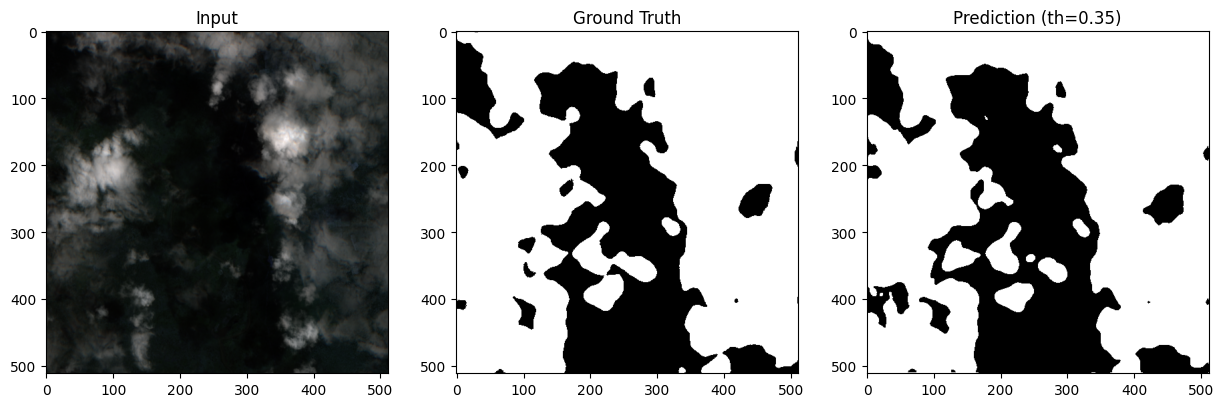

Validation: 100%|██████████| 265/265 [00:31<00:00,  8.33it/s]


Train Loss: 0.5435 | Val Loss: 0.3422
Val Dice: 0.9463±0.2529 | Threshold: 0.35
Precision: 0.9602 | Recall: 0.9488 | F1: 0.9545
New best model! Val Dice: 0.9463

Epoch 2/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.31it/s]


Train Loss: 0.3669 | Val Loss: 0.3176
Val Dice: 0.9370±0.2276 | Threshold: 0.14
Precision: 0.9501 | Recall: 0.9545 | F1: 0.9523

Epoch 3/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.24it/s]


Train Loss: 0.3162 | Val Loss: 0.2752
Val Dice: 0.9503±0.2325 | Threshold: 0.44
Precision: 0.9627 | Recall: 0.9533 | F1: 0.9580
New best model! Val Dice: 0.9503

Epoch 4/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.16it/s]


Train Loss: 0.2949 | Val Loss: 0.3336
Val Dice: 0.9394±0.2187 | Threshold: 0.10
Precision: 0.9521 | Recall: 0.9630 | F1: 0.9575

Epoch 5/50


Validation: 100%|██████████| 265/265 [00:33<00:00,  7.83it/s]


Train Loss: 0.2846 | Val Loss: 0.2412
Val Dice: 0.9587±0.2019 | Threshold: 0.31
Precision: 0.9622 | Recall: 0.9677 | F1: 0.9649
New best model! Val Dice: 0.9587

Epoch 6/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.24it/s]


Train Loss: 0.2752 | Val Loss: 0.2409
Val Dice: 0.9586±0.2067 | Threshold: 0.31
Precision: 0.9626 | Recall: 0.9673 | F1: 0.9650

Epoch 7/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.28it/s]


Train Loss: 0.2668 | Val Loss: 0.2401
Val Dice: 0.9571±0.2138 | Threshold: 0.18
Precision: 0.9602 | Recall: 0.9713 | F1: 0.9657

Epoch 8/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.25it/s]


Train Loss: 0.2671 | Val Loss: 0.2366
Val Dice: 0.9579±0.1996 | Threshold: 0.23
Precision: 0.9615 | Recall: 0.9694 | F1: 0.9654

Epoch 9/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.30it/s]


Train Loss: 0.2563 | Val Loss: 0.2865
Val Dice: 0.9464±0.2114 | Threshold: 0.10
Precision: 0.9611 | Recall: 0.9640 | F1: 0.9626

Epoch 10/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.33it/s]


Train Loss: 0.2552 | Val Loss: 0.2388
Val Dice: 0.9564±0.2024 | Threshold: 0.18
Precision: 0.9630 | Recall: 0.9679 | F1: 0.9655

Epoch 11/50


Validation:   0%|          | 0/265 [00:00<?, ?it/s]

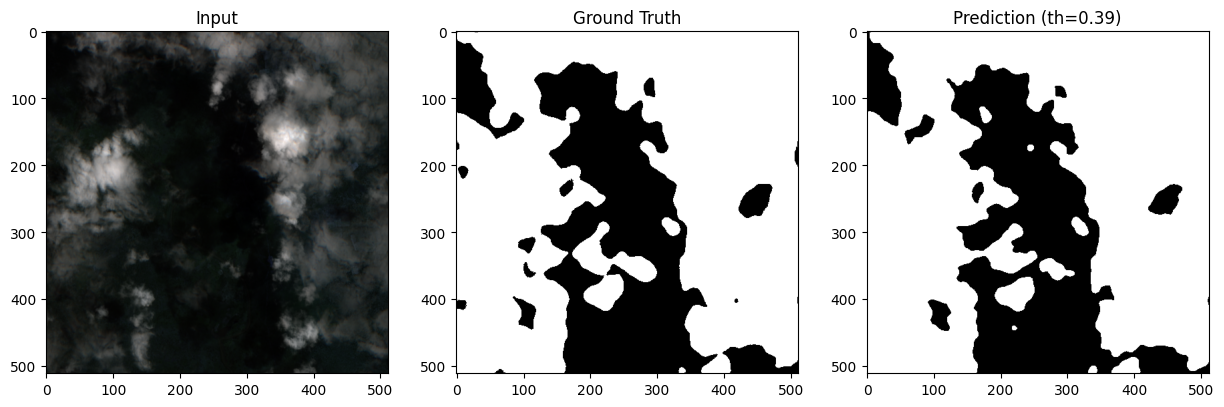

Validation: 100%|██████████| 265/265 [00:31<00:00,  8.29it/s]


Train Loss: 0.2550 | Val Loss: 0.2386
Val Dice: 0.9608±0.2116 | Threshold: 0.39
Precision: 0.9636 | Recall: 0.9678 | F1: 0.9657
New best model! Val Dice: 0.9608

Epoch 12/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.41it/s]


Train Loss: 0.2504 | Val Loss: 0.2503
Val Dice: 0.9528±0.1999 | Threshold: 0.18
Precision: 0.9642 | Recall: 0.9621 | F1: 0.9631

Epoch 13/50


Validation: 100%|██████████| 265/265 [00:39<00:00,  6.66it/s]


Train Loss: 0.2473 | Val Loss: 0.2314
Val Dice: 0.9582±0.1887 | Threshold: 0.23
Precision: 0.9655 | Recall: 0.9667 | F1: 0.9661

Epoch 14/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.25it/s]


Train Loss: 0.2468 | Val Loss: 0.2466
Val Dice: 0.9539±0.2074 | Threshold: 0.14
Precision: 0.9605 | Recall: 0.9678 | F1: 0.9642

Epoch 15/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.19it/s]


Train Loss: 0.2458 | Val Loss: 0.2405
Val Dice: 0.9553±0.2382 | Threshold: 0.23
Precision: 0.9593 | Recall: 0.9695 | F1: 0.9644

Epoch 16/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.19it/s]


Train Loss: 0.2445 | Val Loss: 0.2451
Val Dice: 0.9520±0.1856 | Threshold: 0.10
Precision: 0.9589 | Recall: 0.9712 | F1: 0.9650

Epoch 17/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.26it/s]


Train Loss: 0.2431 | Val Loss: 0.2315
Val Dice: 0.9604±0.1871 | Threshold: 0.31
Precision: 0.9664 | Recall: 0.9675 | F1: 0.9669

Epoch 18/50


Validation: 100%|██████████| 265/265 [00:33<00:00,  7.85it/s]


Train Loss: 0.2338 | Val Loss: 0.2366
Val Dice: 0.9563±0.1839 | Threshold: 0.18
Precision: 0.9675 | Recall: 0.9657 | F1: 0.9666

Epoch 19/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.28it/s]


Train Loss: 0.2302 | Val Loss: 0.2290
Val Dice: 0.9600±0.1869 | Threshold: 0.23
Precision: 0.9630 | Recall: 0.9710 | F1: 0.9670

Epoch 20/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.35it/s]


Train Loss: 0.2326 | Val Loss: 0.2491
Val Dice: 0.9505±0.2034 | Threshold: 0.14
Precision: 0.9630 | Recall: 0.9662 | F1: 0.9646

Epoch 21/50


Validation:   0%|          | 0/265 [00:00<?, ?it/s]

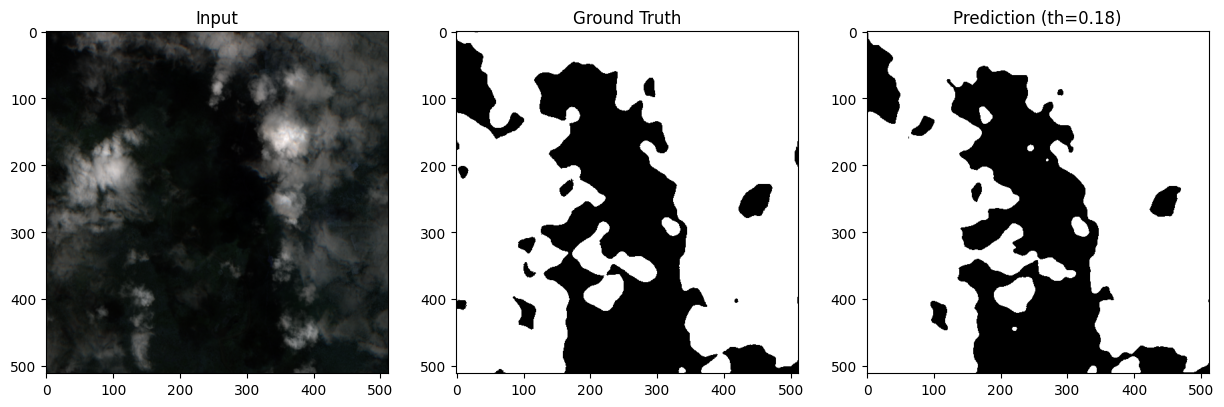

Validation: 100%|██████████| 265/265 [00:32<00:00,  8.13it/s]


Train Loss: 0.2313 | Val Loss: 0.2386
Val Dice: 0.9567±0.1895 | Threshold: 0.18
Precision: 0.9645 | Recall: 0.9673 | F1: 0.9659
No improvement for 10 epochs. Early stopping!

Evaluating on test set...
Critical error: Error(s) in loading state_dict for SlimUNet:
	size mismatch for inc.double_conv.0.weight: copying a param with shape torch.Size([64, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 4, 3, 3]).
	size mismatch for inc.double_conv.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for inc.double_conv.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for inc.double_conv.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for inc.double_conv.1.running_mean: copying a param with shape torch.Size([64]) from checkpoi

In [9]:
torch.multiprocessing.set_sharing_strategy('file_system')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    train_model()
except Exception as e:
    print(f"Critical error: {e}")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Train: 8458, Val: 1058, Test: 1058

Evaluating on test set...


Validation:   0%|          | 0/1058 [00:00<?, ?it/s]

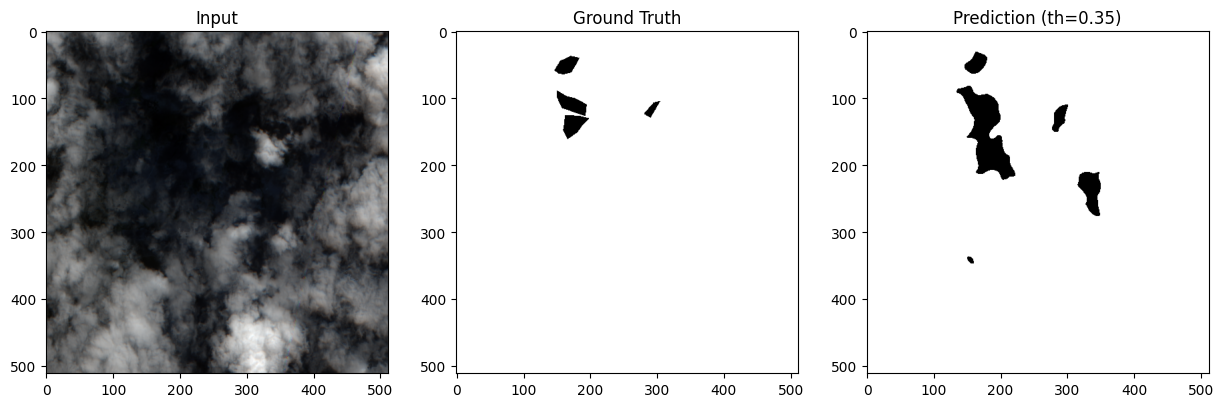

Validation: 100%|██████████| 1058/1058 [00:48<00:00, 21.89it/s]


--- Test Metrics ---
Validation Threshold Used: 0.35
Test Loss: 0.2536
Test Dice: 0.8882±0.2174
Test IoU: 0.8437±0.2333
Precision: 0.9548 | Recall: 0.9701 | F1: 0.9624


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TESTONLY = True  # Set to True for testing only
if TESTONLY:
    batch_size = 4

    try:
        train_set, val_set, test_set = prepare_datasets('../data/processed')
    except Exception as e:
        print(f"Error preparing datasets: {e}")
        exit(1)

    pos_weight_value = compute_pos_weight(train_set)
    pos_weight = torch.tensor([pos_weight_value]).to(device)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

    model = SlimUNet(n_channels=4, n_classes=1).to(device)
    bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    dice = DiceLoss()

    def combined_loss_fn(logits, targets):
        return bce(logits, targets) + dice(logits, targets)

    criterion = combined_loss_fn

    test_model(model, test_loader, criterion, device)